<a href="https://colab.research.google.com/github/wldopie/ESAA/blob/main/HW_220516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **08. 분류 실습 - 캐글 산탄데르 고객 만족 예측**
  - 고객 만족 여부를 XGBoost와 lightGBM을 활용해 예측
  - 피처 명은 익명, 레이블 명은 TARGET
    - `TARGET = 1` : `불만`을 가진 고객
    - `TARGET = 0` : `만족`한 고객
  - 모델의 성능 평가는 ROC-AUC 곡선으로 평가

#### **a. 데이터 전처리**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('/content/train_santander.csv', encoding = 'latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head()

dataset shape: (76020, 371)


ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
0                      0.0                      0.0  ...   
1                      0.0                      0.0  ...   
2                      0.0                      0.0  ...   
3                      0.0                      0.0  ...   
4                      0.0                      0.0  ...   

   saldo_medio_var33_hace2  saldo_medio_var33_hace3  saldo_medio_var33_ult1  \
0                      0.0                      0.0                     0.0   
1                      0.0                      0.0                     0.0   
2                      0.0                      0.0                     0.0   
3                      0.0                      0.0                     0.0   
4                      0.0                      0.0                     0.0   

   saldo_medio_var33_ult3  saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
0                     0.0                      0.0                      0.0   
1                     0.0                      0.0                      0.0   
2                     0.0                      0.0                      0.0   
3                     0.0                      0.0                      0.0   
4                     0.0                      0.0                      0.0   

   saldo_medio_var44_ult1  saldo_medio_var44_ult3          var38  TARGET  
0                     0.0                     0.0   39205.170000       0  
1                     0.0                     0.0   49278.030000       0  
2                     0.0                     0.0   67333.770000       0  
3                     0.0                     0.0   64007.970000       0  
4                     0.0                     0.0  117310.979016       0  

[5 rows x 371 columns]

> 클래스 값 칼럼을 포함한 `피처가 371개` 존재한다.

In [3]:
# 피처의 타입과 Null 값 확인
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


> `111개의` 피처가 `float형`, `260개의` 피처가 `int형`으로 모든 피처가 숫자형이며, Null값은 없다.

In [4]:
# 레이블 분포도 확인
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


> 대부분이 만족이며, `불만족`인 고객은 `4%`에 불과하다.

In [5]:
# 피처의 값 분포 확인
cust_df.describe()

ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.000000       2.000000     28.000000            0.000000   
75%    113748.750000       2.000000     40.000000            0.000000   
max    151838.000000     238.000000    105.000000       210000.000000   

       imp_op_var39_comer_ult1  imp_op_var39_comer_ult3  \
count             76020.000000             76020.000000   
mean                 72.363067               119.529632   
std                 339.315831               546.266294   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               12888.030000             21024.810000   

       imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
count             76020.000000             76020.000000   
mean                  3.559130                 6.472698   
std                  93.155749               153.737066   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max                8237.820000             11073.570000   

       imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  ...  \
count             76020.000000             76020.000000  ...   
mean                  0.412946                 0.567352  ...   
std                  30.604864                36.513513  ...   
min                   0.000000                 0.000000  ...   
25%                   0.000000                 0.000000  ...   
50%                   0.000000                 0.000000  ...   
75%                   0.000000                 0.000000  ...   
max                6600.000000              6600.000000  ...   

       saldo_medio_var33_hace2  saldo_medio_var33_hace3  \
count             76020.000000             76020.000000   
mean                  7.935824                 1.365146   
std                 455.887218               113.959637   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max               50003.880000             20385.720000   

       saldo_medio_var33_ult1  saldo_medio_var33_ult3  \
count            76020.000000            76020.000000   
mean                12.215580                8.784074   
std                783.207399              538.439211   
min                  0.000000                0.000000   
25%                  0.000000                0.000000   
50%                  0.000000                0.000000   
75%                  0.000000                0.000000   
max             138831.630000            91778.730000   

       saldo_medio_var44_hace2  saldo_medio_var44_hace3  \
count             76020.000000             76020.000000   
mean                 31.505324                 1.858575   
std                2013.125393               147.786584   
min                   0.000000                 0.000000   
25%                   0.000000                 0.000000   
50%                   0.000000                 0.000000   
75%                   0.000000                 0.000000   
max              438329.220000             24650.010000   

       saldo_medio_var44_ult1  saldo_medio_var44_ult3         var38  \
count            76020.000000            76020.000000  7.602000e+04   

> var3의 -999999는 특정값을 변환한 것이다. 따라서 -999999를 가장 값이 많은 2로 변환한다. 또한, ID 피처는 단순 식별자에 불과하므로 피처를 드롭한다. 마지막으로 클래스 데이터 세트와 피처 데이터 세트를 분리해 별도의 데이터 세트로 저장한다. 

In [6]:
# var3의 -999999를 2로 변환
cust_df['var3'].replace(-999999, 2, inplace = True)
# ID 피처를 삭제
cust_df.drop('ID', axis = 1, inplace = True)

# 피처 세트와 레이블 세트 분리. 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


> 학습, 성능 평가를 위해 학습 데이터 세트와 테스트 데이터 세트를 분리한다. 비대칭한 데이터 세트이므로, TARGET의 값 분포도가 학습, 테스트 데이터에 비슷하게 추출되었는지도 확인한다.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts() / test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


> 학습, 테스트 데이터 세트 모두 TARGET의 값의 분포가 원본 데이터와 유사하게 전체 데이터의 4% 정도의 불만족 값을 갖도록 만들어졌다. 

#### **b, XGBoost 모델 학습과 하이퍼 파라미터 튜닝**
  - XGBoost의 학습 모델 생성
  - 예측 결과를 ROC-AUC로 평가

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500, random_state는 예제 수행 시마다 동일 예측 결과를 위해 설정
xgb_clf = XGBClassifier(n_estimators = 500, random_stae = 156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
            eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC:{0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

> 테스트 데이터로 예측 시, `ROC AUC`는 약 `0.8419`이다. 

In [9]:
# XGBoost의 하이퍼 파라미터 튜닝
# max_depth, min_child_weight, colsample_bytree 하이퍼 파라미터만 일차 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth':[5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75]}

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

> `하이퍼 파라미터`를 적용한 후, `0.8461`로 조금 개선되었다.

In [10]:
# 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화 진행
# n_estimators는 1000으로 증가시키고, learning_rate = 0.02로 감소, reg_alpha = 0.03으로 추가
xgb_clf = XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 5,
                        min_child_weight = 1, colsample_bytree = 0.5, reg_alpha = 0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric = 'auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.817665	validation_1-auc:0.814986
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.81987	validation_1-auc:0.814699
[2]	validation_0-auc:0.818798	validation_1-auc:0.813863
[3]	validation_0-auc:0.821696	validation_1-auc:0.815841
[4]	validation_0-auc:0.827716	validation_1-auc:0.822558
[5]	validation_0-auc:0.822253	validation_1-auc:0.818887
[6]	validation_0-auc:0.825218	validation_1-auc:0.818733
[7]	validation_0-auc:0.826898	validation_1-auc:0.820357
[8]	validation_0-auc:0.832836	validation_1-auc:0.827253
[9]	validation_0-auc:0.833574	validation_1-auc:0.827534
[10]	validation_0-auc:0.832205	validation_1-auc:0.825896
[11]	validation_0-auc:0.829664	validation_1-auc:0.824912
[12]	validation_0-auc:0.828593	validation_1-auc:0.824409
[13]	validation_0-auc:0.829674	validation_1-auc:0.824657
[14]	validation_0-auc:0.833554	validation_1-auc:0.82782

> `ROC AUC`가 약 `0.8459`으로 살짝 감소한 결과를 보인다. 아쉬운 점은, XGBoost가 GBM보다는 빠르지만, GBM을 기반으로 하고 있어 수행 시간이 상당히 많이 요구된다는 것이다. 

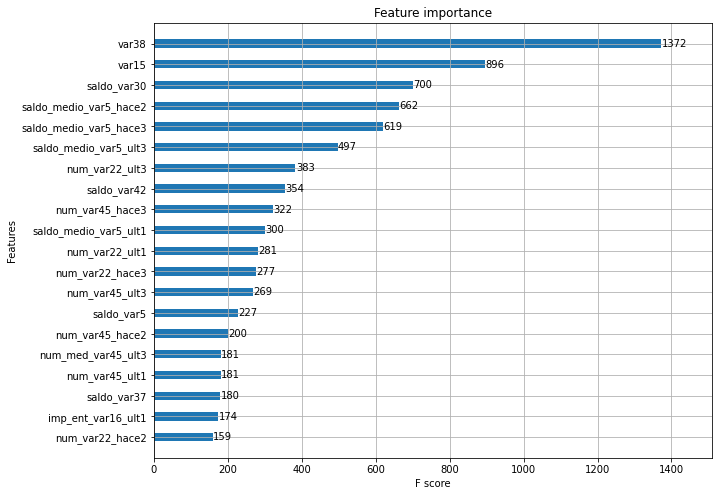

In [11]:
# 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 표시
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

> XGBoost의 예측 성능을 좌우하는 가장 `중요한 피처`는 `var38`, `var15` 순이다. 

#### **c. LightGBM 모델 학습과 하이퍼 파라미터 튜닝**
  - 앞에서 만들어진 데이터 세트를 기반으로 LightGBM으로 학습을 수행하고, ROC-AUC 측정
  - n_estimators = 500, early_stopping_rounds = 100, 평가 데이터 테스트는 테스트 데이터 세트, eval_metric은 auc로 설정한다.

In [12]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

> `LightGBM` 수행 결과, ROC AUC가 약 `0.8396`을 나타낸다. 

In [13]:
# GridSearchCV를 이용해 다양한 하이퍼 파라미터에 대한 튜닝 수행
# 튜닝 대상은 num_leaves, max_depth, min_child_samples, subsample
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 200으로 감소
lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves' : [32, 64],
          'max_depth' : [128, 160],
          'min_child_samples' : [60, 1000],
          'subsample' : [0.8, 1]}
  
# cv는 3으로 지정
gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832192	valid_0's binary_logloss: 0.147167	valid_1's auc: 0.827305	valid_1's binary_logloss: 0.156391
[4]	valid_0's auc: 0.837507	valid_0's binary_logloss: 0.144132	valid_1's auc: 0.8334	valid_1's binary_logloss: 0.15332
[5]	valid_0's auc: 0.842275	valid_0's binary_logloss: 0.141652	valid_1's auc: 0.836036	valid_1's binary_logloss: 0.150954
[6]	valid_0's auc: 0.844971	valid_0's binary_logloss: 0.139662	valid_1's auc: 0.838026	valid_1's binary_logloss: 0.149041
[7]	valid_0's auc: 0.846612	valid_0's binary_logloss: 0.138002	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.147504
[8]	valid_0's auc: 0.848539	valid_0's binary_logloss: 0.136579	valid_1's auc: 0.839506	v

> 최적 하이퍼 파라미터 결과를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출한다.

In [14]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, subsample = 0.8, min_child_samples = 60,
                          max_depth = 128)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820192	valid_0's binary_logloss: 0.164812
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.826414	valid_0's binary_logloss: 0.15956
[3]	valid_0's auc: 0.833406	valid_0's binary_logloss: 0.155785
[4]	valid_0's auc: 0.835637	valid_0's binary_logloss: 0.152871
[5]	valid_0's auc: 0.838247	valid_0's binary_logloss: 0.150644
[6]	valid_0's auc: 0.838586	valid_0's binary_logloss: 0.148823
[7]	valid_0's auc: 0.839325	valid_0's binary_logloss: 0.147211
[8]	valid_0's auc: 0.839865	valid_0's binary_logloss: 0.145884
[9]	valid_0's auc: 0.840581	valid_0's binary_logloss: 0.144795
[10]	valid_0's auc: 0.841319	valid_0's binary_logloss: 0.143802
[11]	valid_0's auc: 0.841103	valid_0's binary_logloss: 0.143097
[12]	valid_0's auc: 0.841097	valid_0's binary_logloss: 0.142537
[13]	valid_0's auc: 0.840881	valid_0's binary_logloss: 0.141955
[14]	valid_0's auc: 0.840806	valid_0's binary_logloss: 0.141507
[15]	valid_0's auc: 0.841103	valid_0's binary_loglo

> LightGBM의 경우, `테스트 데이터` 세트에서 ROC AUC가 약 `0.8416`로 측정되었다. 

---

### **09. 분류 실습 - 캐글 신용카드 사기 검출**
  - 레이블 : Class
    - `Class = 1` : 신용카드 `사기 트랜잭션`
    - `Class = 0` : `정상적인` 신용카드 `트랜잭션`
    - 전체 데이터의 약 `0.172%`만이 레이블 값이 1, 즉 `사기 트랜잭션`이다. 

#### **a. 언더 샘플링과 오버 샘플링의 이해**
  - **`배경`**
    - `레이블이 불균형한` 분포를 가진 `데이터 세트를 학습`시킬 때, `예측 성능의 문제`가 발생한다. 
    - 이상 레이블을 가지는 데이터 건수는 매우 작기 때문에 제대로 다양한 유형을 학습하지 못하는 반면, 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어렵다.

  - **`해결방안`**
    - 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는, `적절한 학습 데이터를 확보`하는 방안이 필요하다.
    - `오버 샘플링 (Oversampling)`
      - 예측 성능상 더 유리한 경우가 많아 주로 사용
      - `적은 데이터 세트를 증식`하여 학습을 위한 충분한 데이터를 확보
      - SMOTE 방법
        - 적은 데이터 세트의 개별 데이터들의 KNN을 찾아 이 데이터와 K개의 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간씩 차이가 나는 새로운 데이터들을 생성하는 방식
    - `언더 샘플링 (Undersampling)`
      - `많은 데이터 세트`를 적은 데이터 세트 수준으로 `감소`
      - 너무 많은 정상 레이블 데이터를 감소시키므로, 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점

#### **b. 데이터 일차 가공 및 모델 학습/예측/평가**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('/content/creditcard.csv')
card_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

> Time 피처의 경우, 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없으므로 제거한다. Amount 피처는 신용카드 트랜잭션 금액을 의미한다.

In [16]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

> Null값은 존재하지 않으며, Class 레이블만 int형이고 나머지 피처들은 전부 float형이다.

> 이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해본다. 

In [17]:
# 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preprocessed_df() 함수 생성
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤, Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  df_copy.drop('Time', axis = 1, inplace = True)
  return df_copy

In [18]:
# get_preprocessed_df()를 호출한 뒤 학습 피처/레이블 데이터, 테스트 피처/레이블 데이터를 반환하는 get_train_test_dataset() 함수 생성
# get_train_test_dataset()는 내부에서 train_test_split() 함수를 호출하며, 
# 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 동일하게 만듦

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:, :-1]
  y_target = df_copy.iloc[:, -1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify = y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = \
  train_test_split(X_features, y_target, test_size = 0.3, random_state = 0, stratify = y_target)
  # 학습과 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

> 생성된 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해 비슷하게 분할되었는지를 확인한다.

In [19]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts() / y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts() / y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


> 큰 차이가 없이 잘 분할된 것을 확인할 수 있다.

> 이제 모델을 만들어 보자. `로지스틱 회귀`와 `LightGBM` 기반의 모델이 데이터 가공을 수행하면서 `예측 성능이 어떻게 변하는지 확인`한다.

In [20]:
# 로지스틱 회귀를 이용해 신용 카드 사기 여부 예측
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred = None, pred_proba = None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216, F1: 0.7244, AUC: 0.9609


> 테스트 데이터로 측정 시 `재현율`이 `0.6216`, `ROC-AUC`가 `0.9609`이다.

In [21]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
  model.fit(X_train, y_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:, 1]
  get_clf_eval(tgt_test, pred, pred_proba)

> 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로, LGBMClassifier 객체 생성 시 `boost_from_average = False`로 설정해야 한다. 

In [22]:
# LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가 수행
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC: 0.9797


> `재현율 0.7568`, `ROC-AUC 0.9797`로 앞의 `로지스틱 회귀보다 높은 수치`를 나타낸다. 

#### **c. 데이터 분포도 변환 후 모델 학습/예측/평가**
  - 왜곡된 분포도를 가지는 데이터를 재가공한 뒤, 모델을 다시 테스트한다.
  - 먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴보자.
    - Amount 피처는 신용 카드 사용 금액으로, 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. 따라서 Amount의 분포도를 확인한다.

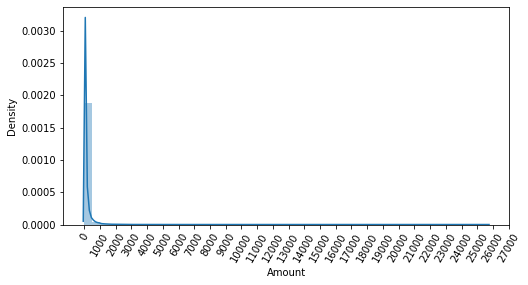

In [23]:
import seaborn as sns
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 30000, 1000), rotation = 60)
sns.distplot(card_df['Amount'])

> 사용금액이 1000불 이하인 데이터가 대부분이므로, `Amount`를 표준 `정규 분포 형태로 변환`한 뒤에 로지스틱 회귀의 예측 성능을 측정해보자.

In [24]:
# 앞에서 생성한 get_processed_df()를 수정한 get_preprocessed_df() 함수 생성
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy

In [25]:
# get_train_test_dataset()를 호출해 학습/테스트 데이터 생성
# get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가

# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 진행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train,
                     tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC: 0.9773


> 교재에는 생략되어 있으나, boost_from_average = True가 디폴트이므로 `boost_from_average = False`를 추가한다.

> 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았다. 따라서 이번에는 StandardScaler 대신 `로그 변환을 수행`한다.

In [26]:
def get_preprocessed_df(df = None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
  return df_copy

In [27]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9786


> 두 모델 모두 `정밀도`, `ROC-AUC`에서 약간씩 `성능이 개선`되었으나, 재현율에서는 성능이 개선되지 않았다,

#### **d. 이상치 데이터 제거 후 모델 학습/예측/평가**
  - `IQR`
    - 이상치 데이터를 찾아내는 방법
    - 사분위 값의 편차를 이용하는 기법으로, 흔히 `박스 플롯(Box Plot) 방식으로 시각화`할 수 있다.
    - `Q3 - Q1`으로 계산
    - Max : Q3 + 1.5 * IQR, Min : Q1 - 1.5 * IQR이므로, `Max와 Min을 넘어가는 데이터`를 `이상치로 간주`한다.

> 이상치 데이터를 IQR을 이용해 제거한다. 많은 피처가 있을 경우, 결정값과 상관성이 가장 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 따라서 각 피처별 상관도를 확인한다.

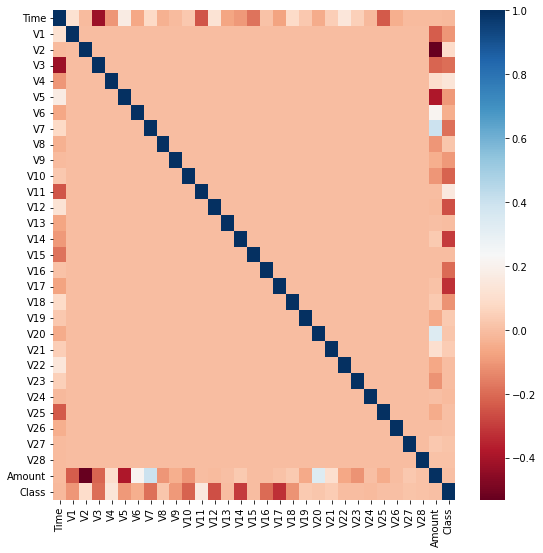

In [28]:
# 각 피처별로 상관도를 구한 뒤 heatmap을 통해 시각화
import seaborn as sns

plt.figure(figsize = (9,9))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu')

> 결정 레이블인 `Class 피처와 음의 상관관계가 가장 높은 피처`는 `V14`와 `V17`이다. 이 중 V14에 대해서만 이상치를 찾아 제거한다. 

In [29]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4분위와 3/4분위 지점을 np.percentile로 구함.
  fraud = df[df['Class'] == 1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR을 구하고, IQR 1.5를 곱해 최댓값과 최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr * weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [30]:
# get_outlier() 함수를 이용해 V14 칼럼에서 이상치 데이터 확인
outlier_index = get_outlier(df = card_df, column = 'V14', weight = 1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


> 총 `4개`의 데이터인 8296, 8615, 9035, 9252번 Index가 `이상치로 추출`되었다. 

In [31]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC: 0.9831


> 이상치 데이터를 제거한 뒤, `로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상`되었음을 확인할 수 있다. `로지스틱 회귀`의 경우 `0.6014`에서 `0.6712`로, `LightGBM`의 경우도 `0.7635`에서 `0.8288`로 크게 증가했다. 

#### **e. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)             # fit_sample 대신 fit_resample 사용
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [35]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743


> 로지스틱 회귀 모델의 경우, SMOTE로 오버 샘플링된 데이터로 학습하면 재현율이 92

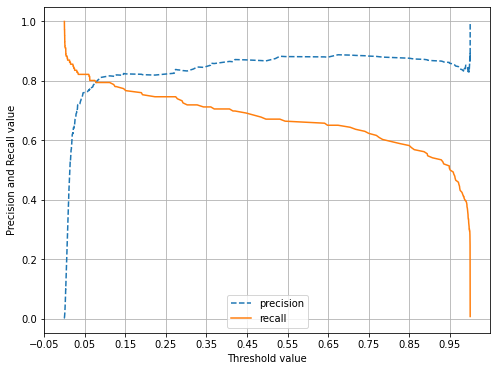

In [36]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_proba_c1):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행 (정밀도는 점선으로 표시)
  plt.figure(figsize = (8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')

  # threshold 값 X축의 Scale을 0.1단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

In [37]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train = X_train_over, ftr_test = X_test, tgt_train = y_train_over, tgt_test = y_test)

오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC: 0.9831
